# Part IV : Should You Buy Board Games On Kickstarter?

This notebook focuses on the question whether board games released on Kickstarter are better (i.e., have higher ratings).

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import matplotlib.patheffects as path_effects

from sqlalchemy import create_engine

engine = create_engine("sqlite:///../data/database/data_2018-05-10.db")

The first step is to create a `DataFrame` of the `boardgames` table that only contains the board games that belong to the `Crowdfunding: Kickstarter` family (bgg_id=8374).

In [2]:
subquery_boardgame_ids_with_kickstarter_family = "SELECT ftb.boardgame_id AS boardgame_id FROM families_to_boardgames ftb " \
"INNER JOIN families f ON ftb.family_id=f.id WHERE f.bgg_id=8374"

query_kickstarter_boardgames = "SELECT id, bgg_id, name, avg_rating, num_ratings FROM boardgames WHERE id IN (" +\
subquery_boardgame_ids_with_kickstarter_family + ");"

kickstarter_boardgames_df = pd.read_sql(query_kickstarter_boardgames, engine)
kickstarter_boardgames_df.head()

,id,bgg_id,name,avg_rating,num_ratings
0,379,2324,Last Frontier: The Vesuvius Incident,6.98771,179
1,385,82,Bobby Lee,6.83937,314
2,398,1036,Speculation,6.73223,640
3,847,3475,Shadowfist,7.10812,400
4,977,4842,Monster Derby,6.11875,120


In [3]:
boardgames_df = pd.read_sql("SELECT id, bgg_id, name, avg_rating, num_ratings, year_published FROM boardgames;", engine)
boardgames_df.head()

,id,bgg_id,name,avg_rating,num_ratings,year_published
0,1,215,Tichu,7.60008,11315,1991
1,2,1513,The Republic of Rome,7.54427,3557,1990
2,3,173,Formula Dé,6.98990,7295,1991
3,4,2956,Dirty Minds: The Game of Naughty Clues,3.98691,469,1990
4,5,224,History of the World,7.12808,4092,1991


We will only include boardgames published in 2009 and later to look at board games from the same time period as the kickstarter releases (Kickstarter was launched in 2009). Furthermore we need to exclude the kickstarter games.

In [4]:
boardgames_2009_df = boardgames_df[boardgames_df["year_published"] >= 2009]
boardgames_2009_nonks_df = boardgames_2009_df[~boardgames_2009_df["id"].isin(kickstarter_boardgames_df["id"])]
boardgames_2009_nonks_df.head()

,id,bgg_id,name,avg_rating,num_ratings,year_published
6106,6107,40692,Small World,7.32569,48964,2009
6111,6112,41114,The Resistance,7.37281,29139,2009
6113,6114,43111,Chaos in the Old World,7.67877,12393,2009
6115,6116,54625,Space Hulk (third edition),7.54534,6182,2009
6117,6118,45315,Dungeon Lords,7.43694,11468,2009


Here we will now calculate the *weighted* average rating for Kickstarter board games and non-Kickstarter board games.

In [5]:
total_ks_votes = kickstarter_boardgames_df["num_ratings"].sum()
weighted_ks_rating = kickstarter_boardgames_df["avg_rating"].mul(kickstarter_boardgames_df["num_ratings"]).div(total_ks_votes).sum()
print("The weighted rating for Kickstarter is {0}".format(weighted_ks_rating))
total_nonks_votes = boardgames_2009_nonks_df["num_ratings"].sum()
weighted_nonks_rating = boardgames_2009_nonks_df["avg_rating"].mul(boardgames_2009_nonks_df["num_ratings"]).div(total_nonks_votes).sum()
print("The weighted rating excluding Kickstarter is {0}".format(weighted_nonks_rating))

The weighted rating for Kickstarter is 7.240871756202965
The weighted rating excluding Kickstarter is 7.253185174652396


## Rating Distribution Comparison

Text(1.62,6.63,'6.58')

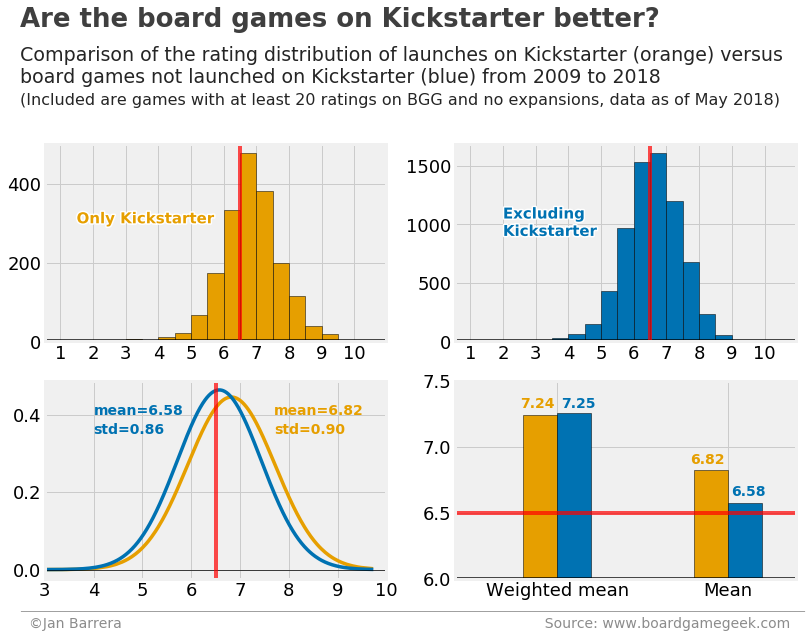

In [6]:
ax1 = plt.subplot(2, 2, 1)
axes = [ax1]
bins = np.arange(1, 11, 0.5)
blue = [0, 114/255, 178/255]
kickstarter_color = [230/255, 159/255, 0/255]

### Top Left: Histogram of the ratings on Kickstarter games ###

# Plotting the histogram for Kickstarter games
ax1 = kickstarter_boardgames_df["avg_rating"].plot(color=[kickstarter_color], kind="hist", bins=bins, edgecolor="black", ax=axes[0], figsize=(12, 8), density=False)
ks_text = ax1.text(1.5, 300, "Only Kickstarter", fontsize=15, color=kickstarter_color, weight="bold")
ks_text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                       path_effects.Normal()])

# Calculating the Normal Distribution (used later in bottom left plot)
sorted_input_ks = sorted(kickstarter_boardgames_df["avg_rating"])
normal_fit_ks = stats.norm.pdf(sorted_input_ks, kickstarter_boardgames_df["avg_rating"].mean(), kickstarter_boardgames_df["avg_rating"].std())

### Top Right: Histogram of the ratings on non-Kickstarter games ###

# Axis
ax2 = plt.subplot(2, 2, 2)
axes.append(ax2)

# Plotting the histogram for non-Kickstarter games
ax2 = boardgames_2009_nonks_df["avg_rating"].plot(color=[blue], kind="hist", bins=bins, edgecolor="black", ax=axes[1], figsize=(12, 8), density=False)
nonks_text = ax2.text(2, 900, "Excluding\nKickstarter", fontsize=15, color=blue, weight="bold")
nonks_text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                       path_effects.Normal()])
 
# Calculating the Normal Distribution (used later in bottom left plot)
sorted_input_nonks = sorted(boardgames_2009_nonks_df["avg_rating"])
normal_fit_nonks = stats.norm.pdf(sorted_input_nonks, boardgames_2009_nonks_df["avg_rating"].mean(), boardgames_2009_nonks_df["avg_rating"].std())

### Bottom Left: The Normal Distributions

# Axis
ax3 = plt.subplot(2, 2, 3)
axes.append(ax3)

# Plotting the Normal Distributions
ax3.plot(sorted_input_ks, normal_fit_ks, color=kickstarter_color, alpha=1, linewidth=3.5)
ax3.plot(sorted_input_nonks, normal_fit_nonks, color=blue, alpha=1, linewidth=3.5)

# Markers for Non-Kickstarter Distribution
ax3.text(4.0, 0.4, "mean=6.58", fontsize=14, color=blue, weight="bold")
ax3.text(4.0, 0.35, "std=0.86", fontsize=14, color=blue, weight="bold")

# Markers for Kickstarter Distribution
ax3.text(7.7, 0.4, "mean=6.82", fontsize=14, color=kickstarter_color, weight="bold")
ax3.text(7.7, 0.35, "std=0.90", fontsize=14, color=kickstarter_color, weight="bold")

# Title and subtitle
ax3.text(x=2.5, y=1.4, s="Are the board games on Kickstarter better?", fontsize=26, weight="bold",
       alpha=0.75)
ax3.text(x=2.5, y=1.2, s="Comparison of the rating distribution of launches on Kickstarter (orange) versus\nboard games not launched on Kickstarter (blue) from 2009 to 2018\n",
       fontsize=19, alpha=0.85)
ax3.text(x=2.5, y=1.2, s="(Included are games with at least 20 ratings on BGG and no expansions, data as of May 2018)",
       fontsize=16, alpha=0.85)

# Signature bar
ax3.text(x=2.5, y=-0.1, s="_____________________________________________________________________________________________________________________________________________________________",
       color="grey", alpha=0.9)
ax3.text(x=2.5, y=-0.15, s="  ©Jan Barrera                                                                                              Source: www.boardgamegeek.com  ",
       fontsize=14, color="grey", alpha=0.9)

### Bottom Right: Comparison of Weighted Means and Means ###

# Axis
ax4 = plt.subplot(2, 2, 4)
axes.append(ax4)

# Axis Settings (All)
x_linewidths = [4, 4, 1, 4]
for index, ax in enumerate(axes):
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)
    ax.tick_params(axis="both", which="major", labelsize=18)
    ax.xaxis.set_ticks(np.arange(1, 11, 1))
    ax.axhline(y=0, color="black", linewidth=x_linewidths[index], alpha=0.7)
    if index != 3:
        ax.axvline(x=6.5, color="red", linewidth=4, alpha=0.7)
ax3.set_xlim([3, 10])

# Bar Charts for Mean and Weighted Mean
ks_mean = kickstarter_boardgames_df["avg_rating"].mean()
nonks_mean = boardgames_2009_nonks_df["avg_rating"].mean()

bar_width = 0.2
indeces = np.asarray([0.5, 1.5])
ticks = indeces + bar_width/2

ax4.axhline(y=6, color="black", linewidth=4, alpha=0.7)
ax4.axhline(y=6.5, color="red", linewidth=4, alpha=0.7)
ax4.set_xlim([0, 2])
ax4.set_ylim([6, 7.5])
ax4.set_xticks(ticks)
ax4.set_xticklabels(["Weighted mean", "Mean"])

ax4.bar(indeces, [weighted_ks_rating, ks_mean], width=bar_width, color=kickstarter_color, edgecolor="black")
ax4.bar(indeces+bar_width, [weighted_nonks_rating, nonks_mean], width=bar_width, color=blue, edgecolor="black")

# Annotations
ax4.text(0.38, 7.3, "7.24", fontsize=14, color=kickstarter_color, weight="bold", rotation=0)
ax4.text(0.62, 7.3, "7.25", fontsize=14, color=blue, weight="bold", rotation=0)

ax4.text(1.38, 6.87, "6.82", fontsize=14, color=kickstarter_color, weight="bold", rotation=0)
ax4.text(1.62, 6.63, "6.58", fontsize=14, color=blue, weight="bold", rotation=0)

If we look at the average of averages the board games Kickstarter appear to be slighty better on average, but if we look at the weighted average there is basically no difference at all. So no, we cannot conclude that the board games on Kickstarter are better.